# Setup

In [1]:
import matplotlib.pyplot as plt
import glob
import numpy as np

In [3]:
def file_lines_to_list(path):
    # open txt file lines to a list
    with open(path) as f:
        content = f.readlines()
    # remove whitespace characters like `\n` at the end of each line
    content = [(x.strip()).split() for x in content]
    return content

# GT-Graph

In [7]:
gt_path = glob.glob("./graphs/bdd100k_60_70_GT/*.txt")

gt_boxes = []
for path in gt_path:
    contents = file_lines_to_list(path)
    for content in contents:
        gt_boxes.append([int(content[1]), int(content[2]), int(content[3]), int(content[4])])
        
print(len(gt_boxes))

In [22]:
sizes = np.zeros(11)
num_sizes = np.zeros(11)

print(sizes)
print(num_sizes)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


[60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70.]
[64. 58. 60. 72. 68. 42. 62. 46. 34. 56. 58.]


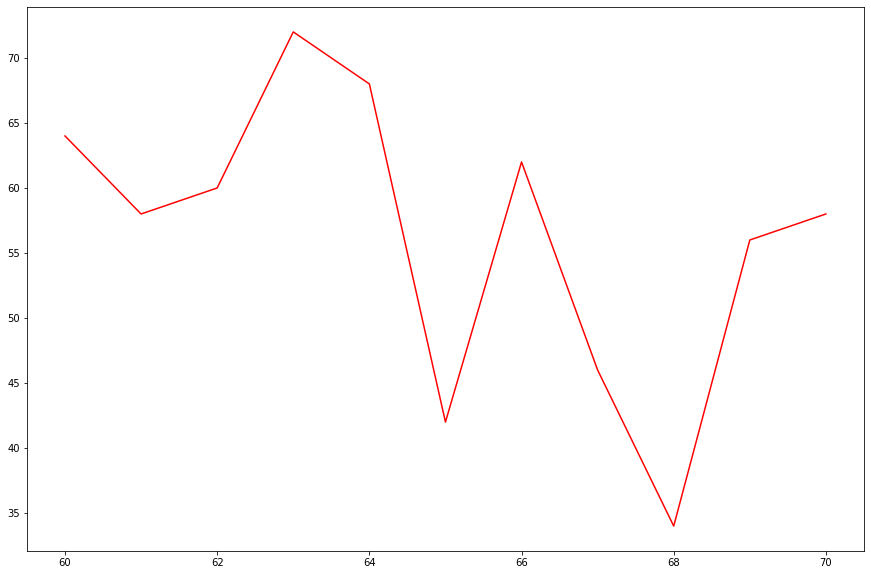

In [28]:
offset = 60

for i in range(len(sizes)):
    sizes[i] = i + offset
print(sizes)

for box in gt_boxes:
    index = box[2] - box[0] - offset
    num_sizes[index] += 1
print(num_sizes)

plt.figure(figsize = (15, 10))
plt.plot(sizes, num_sizes, "r")
plt.show()

# Test Code

In [29]:
#GT Boxes
gt_boxes= {"img_00285.png": [[480, 457, 515, 529], [637, 435, 676, 536]]}
#Pred Boxes
pred_boxs={"img_00285.png": {"boxes": [[330, 463, 387, 505], [356, 456, 391, 521], [420, 433, 451, 498], [328, 465, 403, 540], [480, 477, 508, 522], [357, 460, 417, 537], [344, 459, 389, 493], [485, 459, 503, 511], [336, 463, 362, 496], [468, 435, 520, 521], [357, 458, 382, 485], [649, 479, 670, 531], [484, 455, 514, 519], [641, 439, 670, 532]], "scores": [0.0739, 0.0843, 0.091, 0.1008, 0.1012, 0.1058, 0.1243, 0.1266, 0.1342, 0.1618, 0.2452, 0.8505, 0.9113, 0.972]}}

In [31]:
import numpy as np
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [32]:
def get_model_scores(pred_boxes):
    """Creates a dictionary of from model_scores to image ids.
    Args:
        pred_boxes (dict): dict of dicts of 'boxes' and 'scores'
    Returns:
        dict: keys are model_scores and values are image ids (usually filenames)
    """
    model_score={}
    for img_id, val in pred_boxes.items():
        for score in val['scores']:
            if score not in model_score.keys():
                model_score[score]=[img_id]
            else:
                model_score[score].append(img_id)
    return model_score

In [33]:
def calc_iou( gt_bbox, pred_bbox):
    '''
    This function takes the predicted bounding box and ground truth bounding box and 
    return the IoU ratio
    '''
    x_topleft_gt, y_topleft_gt, x_bottomright_gt, y_bottomright_gt= gt_bbox
    x_topleft_p, y_topleft_p, x_bottomright_p, y_bottomright_p= pred_bbox
    
    if (x_topleft_gt > x_bottomright_gt) or (y_topleft_gt> y_bottomright_gt):
        raise AssertionError("Ground Truth Bounding Box is not correct")
    if (x_topleft_p > x_bottomright_p) or (y_topleft_p> y_bottomright_p):
        raise AssertionError("Predicted Bounding Box is not correct",x_topleft_p, x_bottomright_p,y_topleft_p,y_bottomright_gt)
        
         
    #if the GT bbox and predcited BBox do not overlap then iou=0
    if(x_bottomright_gt< x_topleft_p):
        # If bottom right of x-coordinate  GT  bbox is less than or above the top left of x coordinate of  the predicted BBox
        
        return 0.0
    if(y_bottomright_gt< y_topleft_p):  # If bottom right of y-coordinate  GT  bbox is less than or above the top left of y coordinate of  the predicted BBox
        
        return 0.0
    if(x_topleft_gt> x_bottomright_p): # If bottom right of x-coordinate  GT  bbox is greater than or below the bottom right  of x coordinate of  the predcited BBox
        
        return 0.0
    if(y_topleft_gt> y_bottomright_p): # If bottom right of y-coordinate  GT  bbox is greater than or below the bottom right  of y coordinate of  the predcited BBox
        
        return 0.0
    
    
    GT_bbox_area = (x_bottomright_gt -  x_topleft_gt + 1) * (  y_bottomright_gt -y_topleft_gt + 1)
    Pred_bbox_area =(x_bottomright_p - x_topleft_p + 1 ) * ( y_bottomright_p -y_topleft_p + 1)
    
    x_top_left =np.max([x_topleft_gt, x_topleft_p])
    y_top_left = np.max([y_topleft_gt, y_topleft_p])
    x_bottom_right = np.min([x_bottomright_gt, x_bottomright_p])
    y_bottom_right = np.min([y_bottomright_gt, y_bottomright_p])
    
    intersection_area = (x_bottom_right- x_top_left + 1) * (y_bottom_right-y_top_left  + 1)
    
    union_area = (GT_bbox_area + Pred_bbox_area - intersection_area)
   
    return intersection_area/union_area

In [34]:
def calc_precision_recall(image_results):
    """Calculates precision and recall from the set of images
    Args:
        img_results (dict): dictionary formatted like:
            {
                'img_id1': {'true_pos': int, 'false_pos': int, 'false_neg': int},
                'img_id2': ...
                ...
            }
    Returns:
        tuple: of floats of (precision, recall)
    """
    true_positive=0
    false_positive=0
    false_negative=0
    for img_id, res in image_results.items():
        true_positive +=res['true_positive']
        false_positive += res['false_positive']
        false_negative += res['false_negative']
        try:
            precision = true_positive/(true_positive+ false_positive)
        except ZeroDivisionError:
            precision=0.0
        try:
            recall = true_positive/(true_positive + false_negative)
        except ZeroDivisionError:
            recall=0.0
    return (precision, recall)

In [35]:
def get_single_image_results(gt_boxes, pred_boxes, iou_thr):
    """Calculates number of true_pos, false_pos, false_neg from single batch of boxes.
    Args:
        gt_boxes (list of list of floats): list of locations of ground truth
            objects as [xmin, ymin, xmax, ymax]
        pred_boxes (dict): dict of dicts of 'boxes' (formatted like `gt_boxes`)
            and 'scores'
        iou_thr (float): value of IoU to consider as threshold for a
            true prediction.
    Returns:
        dict: true positives (int), false positives (int), false negatives (int)
    """
    all_pred_indices= range(len(pred_boxes))
    all_gt_indices=range(len(gt_boxes))
    if len(all_pred_indices)==0:
        tp=0
        fp=0
        fn=0
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    if len(all_gt_indices)==0:
        tp=0
        fp=0
        fn=0
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    
    gt_idx_thr=[]
    pred_idx_thr=[]
    ious=[]
    for ipb, pred_box in enumerate(pred_boxes):
        for igb, gt_box in enumerate(gt_boxes):
            iou= calc_iou(gt_box, pred_box)
            
            if iou >iou_thr:
                gt_idx_thr.append(igb)
                pred_idx_thr.append(ipb)
                ious.append(iou)
    iou_sort = np.argsort(ious)[::1]
    if len(iou_sort)==0:
        tp=0
        fp=0
        fn=0
        return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    else:
        gt_match_idx=[]
        pred_match_idx=[]
        for idx in iou_sort:
            gt_idx=gt_idx_thr[idx]
            pr_idx= pred_idx_thr[idx]
            # If the boxes are unmatched, add them to matches
            if(gt_idx not in gt_match_idx) and (pr_idx not in pred_match_idx):
                gt_match_idx.append(gt_idx)
                pred_match_idx.append(pr_idx)
        tp= len(gt_match_idx)
        fp= len(pred_boxes) - len(pred_match_idx)
        fn = len(gt_boxes) - len(gt_match_idx)
    return {'true_positive': tp, 'false_positive': fp, 'false_negative': fn}

In [38]:
#GT Boxes
gt_boxes = [[480, 457, 515, 529], [637, 435, 676, 536]]
#Pred Boxes
pred_boxes = [[330, 463, 387, 505], [356, 456, 391, 521], [420, 433, 451, 498], [328, 465, 403, 540], [480, 477, 508, 522], [357, 460, 417, 537], [344, 459, 389, 493], [485, 459, 503, 511], [336, 463, 362, 496], [468, 435, 520, 521], [357, 458, 382, 485], [649, 479, 670, 531], [484, 455, 514, 519], [641, 439, 670, 532]]

In [41]:
print(len(gt_boxes), len(pred_boxes))

2 14


In [40]:
iou_thr = 0.5
result = get_single_image_results(gt_boxes, pred_boxes, iou_thr)
print(result)

{'true_positive': 2, 'false_positive': 12, 'false_negative': 0}


# Calculate TP/FP

In [31]:
import numpy as np
from copy import deepcopy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from random import randint
import cv2

In [61]:
def get_file_name(path):
    basename = os.path.basename(path)
    onlyname = os.path.splitext(basename)[0]
    return onlyname

In [44]:
def calc_iou(gt_bbox, pred_bbox):
    '''
    This function takes the predicted bounding box and ground truth bounding box and 
    return the IoU ratio
    '''
    x_topleft_gt, y_topleft_gt, x_bottomright_gt, y_bottomright_gt = gt_bbox
    x_topleft_p, y_topleft_p, x_bottomright_p, y_bottomright_p = pred_bbox
    
    if (x_topleft_gt > x_bottomright_gt) or (y_topleft_gt > y_bottomright_gt):
        raise AssertionError("Ground Truth Bounding Box is not correct")
    if (x_topleft_p > x_bottomright_p) or (y_topleft_p > y_bottomright_p):
        raise AssertionError("Predicted Bounding Box is not correct")
        
    #if the GT bbox and predcited BBox do not overlap then iou=0
    if(x_bottomright_gt < x_topleft_p):      
        return 0.0
    if(y_bottomright_gt < y_topleft_p):        
        return 0.0
    if(x_topleft_gt > x_bottomright_p):      
        return 0.0
    if(y_topleft_gt > y_bottomright_p):
        return 0.0
    
    GT_bbox_area = (x_bottomright_gt - x_topleft_gt + 1) * (y_bottomright_gt - y_topleft_gt + 1)
    Pred_bbox_area = (x_bottomright_p - x_topleft_p + 1 ) * (y_bottomright_p - y_topleft_p + 1)
    
    x_top_left = np.max([x_topleft_gt, x_topleft_p])
    y_top_left = np.max([y_topleft_gt, y_topleft_p])
    x_bottom_right = np.min([x_bottomright_gt, x_bottomright_p])
    y_bottom_right = np.min([y_bottomright_gt, y_bottomright_p])
    
    intersection_area = (x_bottom_right - x_top_left + 1) * (y_bottom_right - y_top_left  + 1)
    
    union_area = (GT_bbox_area + Pred_bbox_area - intersection_area)
   
    return intersection_area/union_area

In [188]:
def process_single_image_results(gt_boxes, pred_boxes, iou_thr):
    """Calculates number of true_pos, false_pos, false_neg from single batch of boxes.
    Args:
        gt_boxes (list of list of floats): list of locations of ground truth
            objects as [xmin, ymin, xmax, ymax]
        pred_boxes (dict): dict of dicts of 'boxes' (formatted like `gt_boxes`)
            and 'scores'
        iou_thr (float): value of IoU to consider as threshold for a
            true prediction.
    Returns:
        dict: true positives (int), false positives (int), false negatives (int)
    """
#     all_pred_indices = range(len(pred_boxes))
#     all_gt_indices = range(len(gt_boxes))
#     if len(all_pred_indices)==0:
#         tp=0
#         fp=0
#         fn=0
#         return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
#     if len(all_gt_indices)==0:
#         tp=0
#         fp=0
#         fn=0
#         return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
    detected_obj_boxes = []

    if len(pred_boxes) > 0 and len(gt_boxes) > 0:
    
        gt_idx_thr=[]
        pred_idx_thr=[]
        ious=[]

#         detected_obj_boxes = []

        for igb, gt_box in enumerate(gt_boxes):
            for ipb, pred_box in enumerate(pred_boxes):
                iou = calc_iou(gt_box, pred_box)

                if iou >= iou_thr:
                    detected_obj_boxes.append(gt_box)
    
    return detected_obj_boxes

#                 gt_idx_thr.append(igb)
#                 pred_idx_thr.append(ipb)
#                 ious.append(iou)
#     iou_sort = np.argsort(ious)[::1]
#     if len(iou_sort)==0:
#         tp=0
#         fp=0
#         fn=0
#         return {'true_positive':tp, 'false_positive':fp, 'false_negative':fn}
#     else:
#         gt_match_idx=[]
#         pred_match_idx=[]
#         for idx in iou_sort:
#             gt_idx=gt_idx_thr[idx]
#             pr_idx= pred_idx_thr[idx]
#             # If the boxes are unmatched, add them to matches
#             if(gt_idx not in gt_match_idx) and (pr_idx not in pred_match_idx):
#                 gt_match_idx.append(gt_idx)
#                 pred_match_idx.append(pr_idx)
#         tp= len(gt_match_idx)
#         fp= len(pred_boxes) - len(pred_match_idx)
#         fn = len(gt_boxes) - len(gt_match_idx)
        
#     return {'true_positive': tp, 'false_positive': fp, 'false_negative': fn}

In [64]:
gt_path = glob.glob("./graphs/bdd100k_60_70_GT/*.txt")
img_names = []

for path in gt_path:
    img_name = get_file_name(path)
    img_names.append(img_name)

c98258a4-54a47ff2
GT: [[91, 308, 154, 441]]
Det: [[956, 302, 1034, 525], [1054, 300, 1140, 567], [45, 234, 134, 548], [194, 282, 274, 503], [276, 311, 348, 467], [372, 315, 444, 438]]
Detected_GT: []


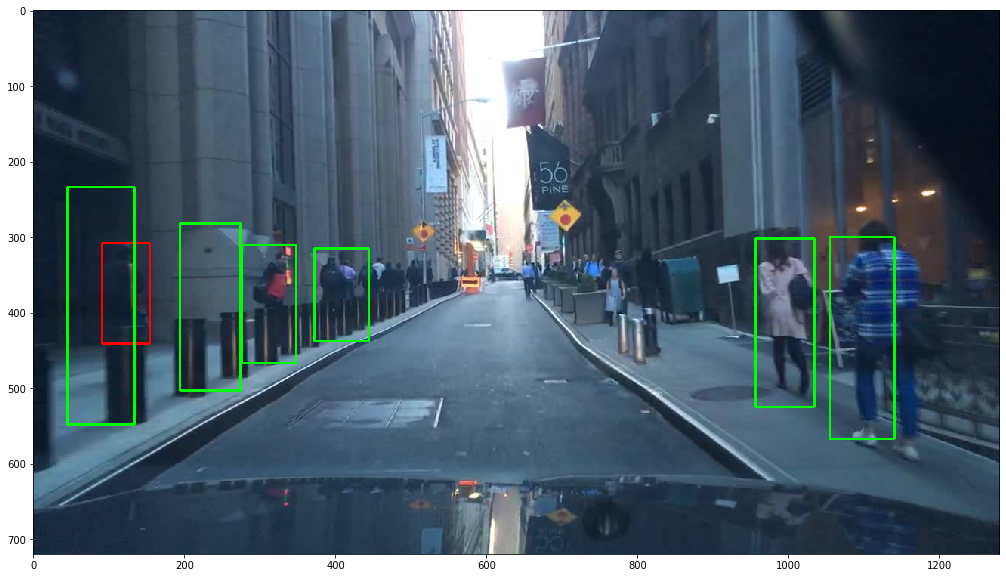

In [186]:
rand_name = img_names[randint(0, len(img_names)-1)]
print(rand_name)

gt_boxes_list = file_lines_to_list(f"./graphs/bdd100k_60_70_GT/{rand_name}.txt")
det_boxes_list = file_lines_to_list(f"./graphs/60_70_person_yolo_custom_epoch_97/{rand_name}.txt")

gt_boxes = []
det_boxes = []

for gt_box in gt_boxes_list:
    gt_boxes.append([int(gt_box[1]), int(gt_box[2]), int(gt_box[3]), int(gt_box[4])])
    
for det_box in det_boxes_list:
    det_boxes.append([int(det_box[2]), int(det_box[3]), int(det_box[4]), int(det_box[5])])

print("GT:", gt_boxes)
print("Det:", det_boxes)

detected_gt_boxes = process_single_image_results(gt_boxes, det_boxes, 0.5)
print("Detected_GT:", detected_gt_boxes)

test_img = plt.imread(f"../datasets/bdd100k/bdd100k/bdd100k/images/100k/val/{rand_name}.jpg")

for obj in gt_boxes:
    rec_img = cv2.rectangle(test_img, (obj[0], obj[1]), (obj[2], obj[3]), (255, 0, 0), thickness = 2)
    
for obj in det_boxes:
    rec_img = cv2.rectangle(rec_img, (obj[0], obj[1]), (obj[2], obj[3]), (0, 255, 0), thickness = 2)

plt.figure(figsize = (18, 10))
plt.imshow(test_img)
plt.show()

In [126]:
gt_path = glob.glob("./graphs/bdd100k_60_70_GT/*.txt")

all_gt_boxes = []
for path in gt_path:
    contents = file_lines_to_list(path)
    for content in contents:
        all_gt_boxes.append([int(content[1]), int(content[2]), int(content[3]), int(content[4])])
        
print(len(all_gt_boxes))

310


In [189]:
all_detected_gt_boxes = []

for path in gt_path:
    img_name = get_file_name(path)
    
    gt_boxes_list = file_lines_to_list(f"./graphs/bdd100k_60_70_GT/{img_name}.txt")
    det_boxes_list = file_lines_to_list(f"./graphs/60_70_person_yolo_custom_epoch_97/{img_name}.txt")

    gt_boxes = []
    det_boxes = []

    for gt_box in gt_boxes_list:
        gt_boxes.append([int(gt_box[1]), int(gt_box[2]), int(gt_box[3]), int(gt_box[4])])

    for det_box in det_boxes_list:
        det_boxes.append([int(det_box[2]), int(det_box[3]), int(det_box[4]), int(det_box[5])])

    detected_gt_boxes = process_single_image_results(gt_boxes, det_boxes, 0.5)
    
    for box in detected_gt_boxes:
        box = np.array(box)
        all_detected_gt_boxes.append(box)

print(len(all_detected_gt_boxes))

219


In [190]:
sizes = np.zeros(11)
gt_num_sizes = np.zeros(11)
det_num_sizes = np.zeros(11)

print(sizes)
print(gt_num_sizes)
print(det_num_sizes)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


[60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70.]
[32. 29. 30. 36. 34. 21. 31. 23. 17. 28. 29.]
[25. 23. 20. 23. 23. 14. 23. 19. 10. 21. 18.]


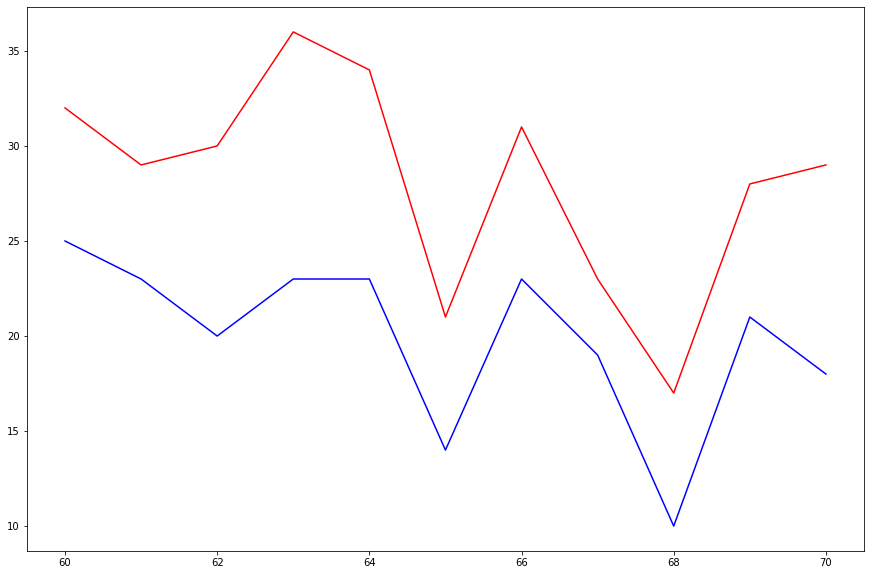

In [191]:
offset = 60

for i in range(len(sizes)):
    sizes[i] = i + offset
print(sizes)

for box in all_gt_boxes:
    index = box[2] - box[0] - offset
    gt_num_sizes[index] += 1
print(gt_num_sizes)

for box in all_detected_gt_boxes:
    index = box[2] - box[0] - offset
    det_num_sizes[index] += 1
print(det_num_sizes)

plt.figure(figsize = (15, 10))
# plt.ylim(0, 50)
plt.plot(sizes, gt_num_sizes, "r")
plt.plot(sizes, det_num_sizes, "b")
plt.show()

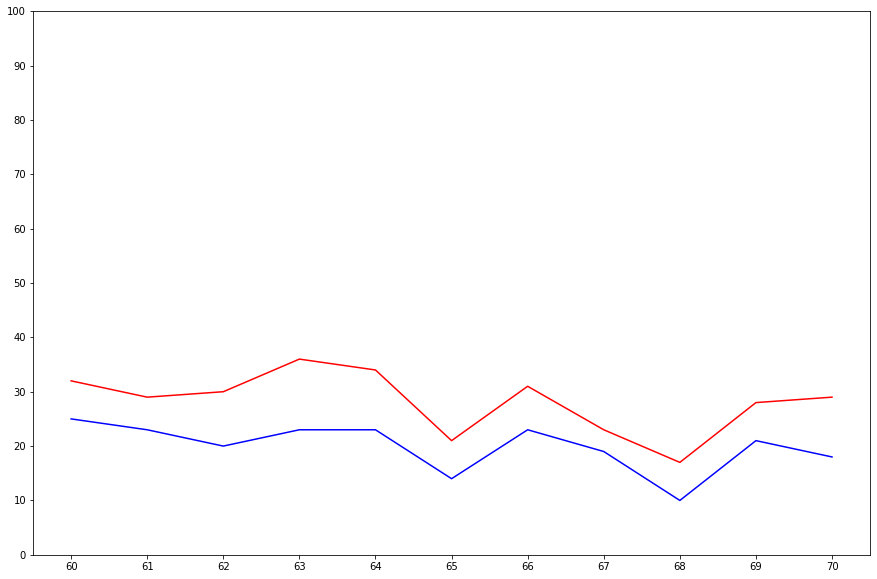

In [198]:
plt.figure(figsize = (15, 10))
plt.ylim(0, 100)
plt.yticks(np.arange(0, 100+1, 10))
plt.xticks(np.arange(60, 70+1, 1.0))
plt.plot(sizes, gt_num_sizes, "r")
plt.plot(sizes, det_num_sizes, "b")
plt.show()

In [53]:
det_path = glob.glob("./graphs/60_70_person_yolo_custom_epoch_97/*.txt")

det_boxes = []
ranged_det_boxes = []

for path in det_path:
    contents = file_lines_to_list(path)
    for content in contents:
        det_boxes.append([int(content[2]), int(content[3]), int(content[4]), int(content[5])])
        if int(content[4]) - int(content[2]) >= 60 and int(content[4]) - int(content[2]) <= 70:
            ranged_det_boxes.append([int(content[2]), int(content[3]), int(content[4]), int(content[5])])
        
print(len(det_boxes), len(ranged_det_boxes))

770 122


In [58]:
sizes = np.zeros(11)
gt_num_sizes = np.zeros(11)
det_num_sizes = np.zeros(11)

print(sizes)
print(gt_num_sizes)
print(det_num_sizes)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


[60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70.]
[32. 29. 30. 36. 34. 21. 31. 23. 17. 28. 29.]
[ 1.  0.  0.  2.  3.  4.  6. 18. 20. 27. 41.]


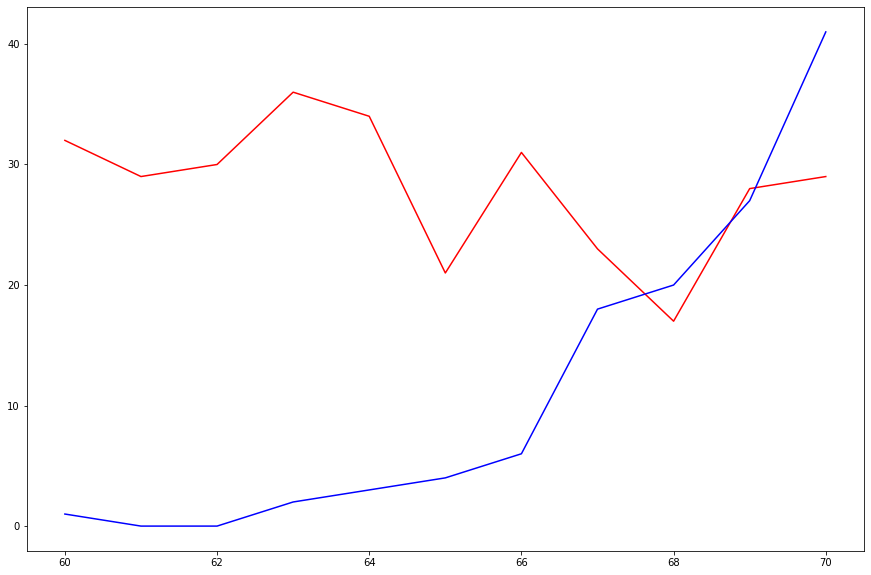

In [59]:
offset = 60

for i in range(len(sizes)):
    sizes[i] = i + offset
print(sizes)

for box in gt_boxes:
    index = box[2] - box[0] - offset
    gt_num_sizes[index] += 1
print(gt_num_sizes)

for box in ranged_det_boxes:
    index = box[2] - box[0] - offset
    det_num_sizes[index] += 1
print(det_num_sizes)

plt.figure(figsize = (15, 10))
plt.plot(sizes, gt_num_sizes, "r")
plt.plot(sizes, det_num_sizes, "b")
plt.show()